In [6]:
data_path = "C:/Thesis/Scripts/vlasov_mms_hermite.npz"

import torch
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch import nn, optim, utils
from torch.utils.data import Dataset, DataLoader, random_split

class PDEDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        inputs = data['inputs']     
        solutions = data['solutions'] 
        forcing = data['forcing']
        
        self.x = torch.from_numpy(inputs).float()
        
        # Handle complex-valued solutions
        if np.iscomplexobj(solutions):
            if solutions.ndim == 3:
                solutions = solutions.reshape(solutions.shape[0], -1)
            
            self.y = torch.complex(
                torch.from_numpy(solutions.real).float(),
                torch.from_numpy(solutions.imag).float()
            )
        else: #back-up for some weird case were data would not be complex
            self.y = torch.from_numpy(solutions).float()
            if self.y.ndim == 3:
                self.y = self.y.view(self.y.size(0), -1)
        
        assert self.x.shape[0] == self.y.shape[0], \
            f"Mismatch: inputs {self.x.shape[0]} vs outputs {self.y.shape[0]}"
        
        if np.iscomplexobj(forcing):
            if forcing.ndim == 3:
                forcing = forcing.reshape(forcing.shape[0], -1)

            self.z = torch.complex(
                torch.from_numpy(forcing.real).float(),
                torch.from_numpy(forcing.imag).float()
            )

    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx], self.y[idx]
    
def integrate(W, values):
    """
    Values shape: (Batch, Time, Velocity) -> (B, 3, 32)
    W shape: (Velocity,) -> (32,)
    Returns: (Batch, Time)
    """
    # Simple trapezoidal-style integration or weighted sum
    # We sum over the last dimension (velocity)
    return torch.sum(values * W, dim=-1)
    
dataset = np.load(data_path)
full_dataset_test = PDEDataset(data_path)
# 1. Check how many samples the Dataset thinks it has
print(f"Dataset length: {len(full_dataset_test)}") 

# 2. Check the shapes of the actual tensors stored inside the class
print(f"Inputs shape: {full_dataset_test.x.shape}")
print(f"Solutions shape: {full_dataset_test.y.shape}")
print(full_dataset_test.z.shape)

# 3. Check the keys inside the .npz file
print(f"Keys in .npz: {dataset.files}")

Dataset length: 1000
Inputs shape: torch.Size([1000, 4])
Solutions shape: torch.Size([1000, 512])
torch.Size([1000, 512])
Keys in .npz: ['inputs', 'solutions', 'forcing']


In [ ]:
class VlasovModel(L.LightningModule):
    def __init__(self, input_dim=4, Nt=16, Nv=32):
        super().__init__()
        self.Nt = Nt
        self.Nv = Nv
        self.output_dim = Nt * Nv

        forcing_size = Nt * Nv * 2
        total_input = forcing_size + input_dim

        self.model = nn.Sequential(
            nn.Linear(total_input, 512),  # Increased for complex output
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_dim * 2)  # *2 for real and imaginary parts
        )
        self.loss_fn = nn.MSELoss()
    
    def forward(self, params, forcing):
        batch_size = params.shape[0]
        
        # Flatten forcing and split real/imag
        forcing_flat = forcing.view(batch_size, -1)  # (batch, Nt*Nv)
        forcing_real_imag = torch.cat([forcing_flat.real, forcing_flat.imag], dim=1)
        
        # Concatenate params and forcing
        x = torch.cat([params, forcing_real_imag], dim=1)
        
        # Forward pass
        out = self.model(x)
        
        # Split into real and imaginary
        real = out[..., :self.output_dim]
        imag = out[..., self.output_dim:]
        
        return torch.complex(real, imag)
    
    def training_step(self, batch, batch_idx):
        params, forcing, solution = batch
        preds = self(params, forcing)
        # Compute loss on both real and imaginary parts
        y_hat = preds.view(-1, 16, 32)
        y_true = solution.view(-1, 16, 32)

        # 2. Define Weights (W)
        # If your velocity grid is uniform from -4 to 4 with 32 points:
        # dv = (4 - (-4)) / (32 - 1)
        W = torch.ones(32, device=self.device) # You can replace with actual integration weights

        # 3. Compute Complex Relative L2 Norm
        # We apply the logic of your 'relativeL2norm_set' but for complex values
        diff_sq = (y_hat.real - y_true.real)**2 + (y_hat.imag - y_true.imag)**2
        true_sq = y_true.real**2 + y_true.imag**2

        # Using the integration logic from your snippets
        # Note: ensure your integrate() function is defined in your scope
        l2_diff = integrate(W, diff_sq)**(0.5)
        l2_norm = integrate(W, true_sq)**(0.5)
        
        # Calculate relative error and average over the batch
        loss_2 = torch.mean(l2_diff / torch.clamp(l2_norm, min=1e-7))
        loss = self.loss_fn(preds.real, solution.real) + self.loss_fn(preds.imag, solution.imag)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        params, forcing, solution = batch
        preds = self(params,forcing)

        y_hat = preds.view(-1, 16, 32)
        y_true = solution.view(-1, 16, 32)

        # 2. Define Weights (W)
        # If your velocity grid is uniform from -4 to 4 with 32 points:
        # dv = (4 - (-4)) / (32 - 1)
        W = torch.ones(32, device=self.device) # You can replace with actual integration weights

        diff_sq = (y_hat.real - y_true.real)**2 + (y_hat.imag - y_true.imag)**2
        true_sq = y_true.real**2 + y_true.imag**2

        l2_diff = integrate(W, diff_sq)**(0.5)
        l2_norm = integrate(W, true_sq)**(0.5)
        
        # Calculate relative error and average over the batch
        val_loss_2 = torch.mean(l2_diff / torch.clamp(l2_norm, min=1e-7))
        
        val_loss = self.loss_fn(preds.real, solution.real) + self.loss_fn(preds.imag, solution.imag)
        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode  | FLOPs
-------------------------------------------------------
0 | model   | Sequential | 1.3 M  | train | 0    
1 | loss_fn | MSELoss    | 0      | train | 0    
-------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.259     Total estimated model params size (MB)
7         Modules in train mode
0         Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:317: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


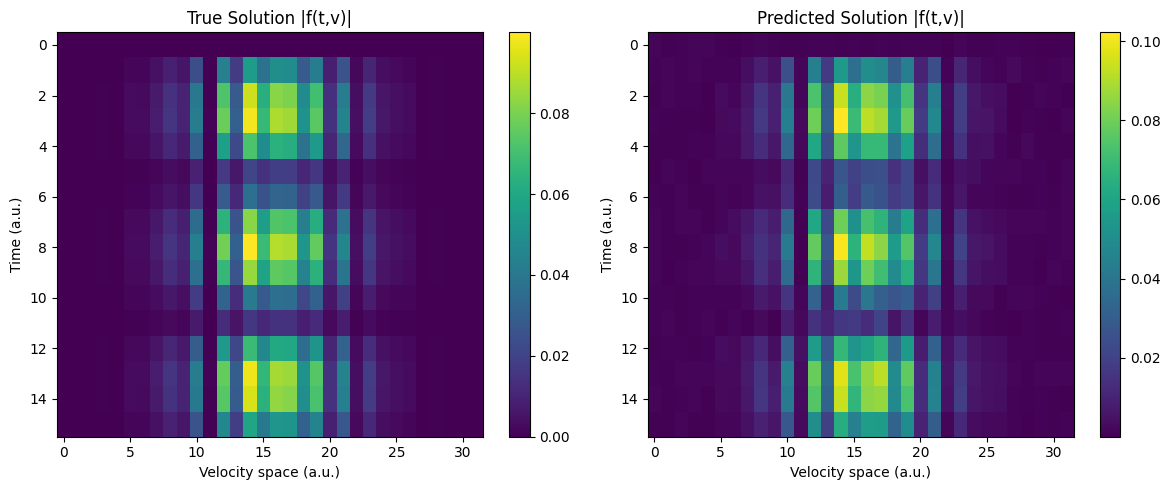

In [14]:
# --- 3. Execution Block ---
if __name__ == "__main__":
    # 1. Load and Split Data
    full_dataset = PDEDataset(data_path)
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32)
    
    # 2. Initialize Model
    model = VlasovModel(input_dim=4, Nt = 16, Nv = 32)  # Changed from 1 to 96
    
    # 3. Train
    trainer = L.Trainer(max_epochs=30, accelerator="auto")
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
    # Visualize
    model.eval()
    params_test, forcing_test, solution_true = next(iter(val_loader))
    
    with torch.no_grad():
        solution_pred = model(params_test, forcing_test)
    
    # Plot first sample
    idx = 0
    true_grid = solution_true[idx].view(16, 32).abs().cpu().numpy()
    pred_grid = solution_pred[idx].view(16, 32).abs().cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    im1 = ax[0].imshow(true_grid, aspect='auto', cmap='viridis')
    ax[0].set_title("True Solution |f(t,v)|")
    ax[0].set_xlabel("Velocity space (a.u.)")
    ax[0].set_ylabel("Time (a.u.)")
    plt.colorbar(im1, ax=ax[0])
    
    im2 = ax[1].imshow(pred_grid, aspect='auto', cmap='viridis')
    ax[1].set_title("Predicted Solution |f(t,v)|")
    ax[1].set_xlabel("Velocity space (a.u.)")
    ax[1].set_ylabel("Time (a.u.)")
    plt.colorbar(im2, ax=ax[1])
    
    plt.tight_layout()
    plt.show()

    

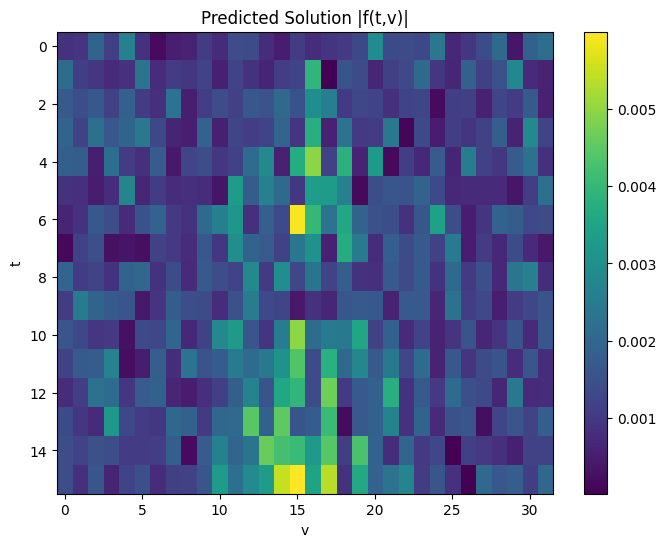

In [4]:
model.eval()

# Create input parameters as tensor with batch dimension
params_custom = torch.tensor([[3.0, 20.0, 0.3, 3.0]], dtype=torch.float32)  # Shape: (1, 4)

Nt = 16
Nv = 32

# Create zero forcing with batch dimension
forcing_custom = torch.zeros(1, Nt, Nv, dtype=torch.complex64)  # Shape: (1, 16, 32)

with torch.no_grad():
    solution_prediction = model(params_custom, forcing_custom)  # Shape: (1, 512)

# Plot the solution
grid = solution_prediction[0].view(16, 32).abs().cpu().numpy()  # [0] removes batch dim

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(grid, aspect='auto', cmap='viridis')
ax.set_title("Predicted Solution |f(t,v)|")
ax.set_xlabel("v")
ax.set_ylabel("t")
plt.colorbar(im, ax=ax)
plt.show()